# Modeling 111101111 - drop features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 534, 917, 969, 1183, 1299) with the features ('LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum') dropped.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111101111.csv")
df.drop(['LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum'], axis=1, inplace=True)

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 4.93 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 4.9903188083313159}

Model with rank: 2
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 4.2069166705789289}

Model with rank: 3
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 5.2701378488367991}



alpha                    RMSE                 std dev
13   14.0  0.10695595807699957713  0.04242061040112877351
12   13.0  0.10674793690296933979  0.04254338065862599272
0     1.0  0.10662834591354634906  0.04741372200993906189
11   12.0  0.10654750999536484468  0.04268303005332788058
10   11.0  0.10635634587151707176  0.04284214471461142426
9    10.0  0.10617658890955941620  0.04302401173079010988
8     9.0  0.10601105843513128346  0.04323287400437363093
1     2.0  0.10599043401253108176  0.04634625527377449206
7     8.0  0.10586356295486457069  0.04347430364085170390
6     7.0  0.10573941788140486797  0.04375576621739050293
2     3.0  0.10571602502888430286  0.04556858117864481111
5     6.0  0.10564634368294342770  0.04408750759703070066
3     4.0  0.10560796234563227247  0.04496663842653182697
4     5.0  0.10559612709835276834  0.04448402032422510421

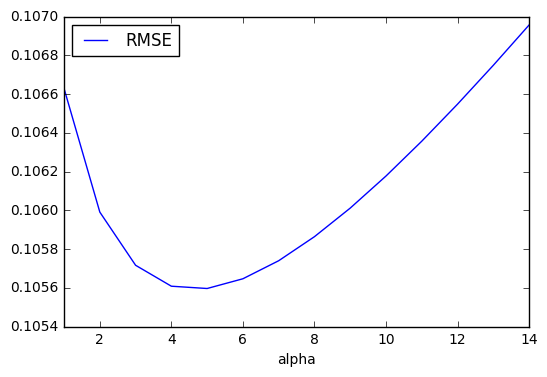

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [16]:
ridge_regr = linear_model.Ridge(alpha = 5)

In [17]:
validate(ridge_regr)

0.11854339143138473

## Lasso

In [13]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [14]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 36.10 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.0002037351294307487}

Model with rank: 2
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.00015062338793250034}

Model with rank: 3
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.00048782644285970991}



alpha                    RMSE                 std dev
5  0.00060000000000000006  0.10477429592169028305  0.04584043101238837598
4  0.00050000000000000001  0.10442208462446038453  0.04583168916718490665
0  0.00010000000000000000  0.10416184296019982691  0.04829186227478527577
3  0.00040000000000000002  0.10394101116807825946  0.04592612334894647513
2  0.00030000000000000003  0.10341223525617115886  0.04625602994857024725
1  0.00020000000000000001  0.10299947005054826965  0.04684633107449963363

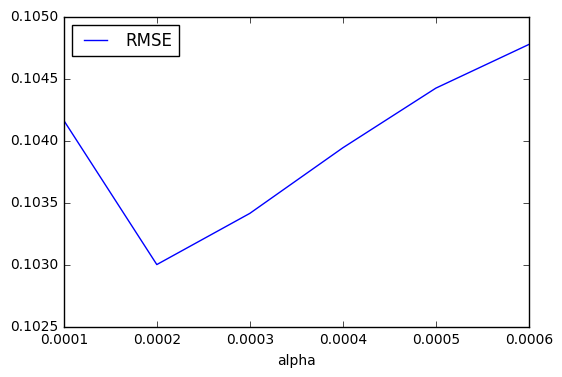

In [15]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [33]:
lasso_regr = linear_model.Lasso(alpha=0.0002, max_iter=50000)

In [34]:
validate(lasso_regr)

0.11486610186339372

## Lasso LARS

In [18]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [19]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.684e-04, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=2.357e-04, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 103 iterations, i.e. alpha=1.244e-04, with an active set of 91 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/leas

RandomizedSearchCV took 10.91 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.002)
Parameters: {'alpha': 8.6701517549833823e-05}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 7.7194867656442929e-05}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 7.2713658361785681e-05}



/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 48 iterations, i.e. alpha=3.684e-04, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=2.357e-04, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 103 iterations, i.e. alpha=1.244e-04, with an active set of 91 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/leas

alpha                    RMSE                 std dev
10  0.00016000000000000007  0.10389911416605880634  0.04780244563022235937
9   0.00015000000000000004  0.10349595496974316189  0.04804952944164858630
8   0.00014000000000000004  0.10313971225199904114  0.04829684962550905014
7   0.00013000000000000004  0.10280431046074772761  0.04852320547503486542
6   0.00012000000000000004  0.10253175896768237929  0.04877562635068101449
0   0.00006000000000000000  0.10249236739443501332  0.05052610964547713662
5   0.00011000000000000003  0.10235355270114304682  0.04906929026513761477
1   0.00007000000000000001  0.10230195252680139573  0.05025508734706045366
4   0.00010000000000000002  0.10224553143798817412  0.04931939850266027492
2   0.00008000000000000002  0.10219191741472001544  0.04999218385833656408
3   0.00009000000000000002  0.10216121513878788363  0.04965119248893015702

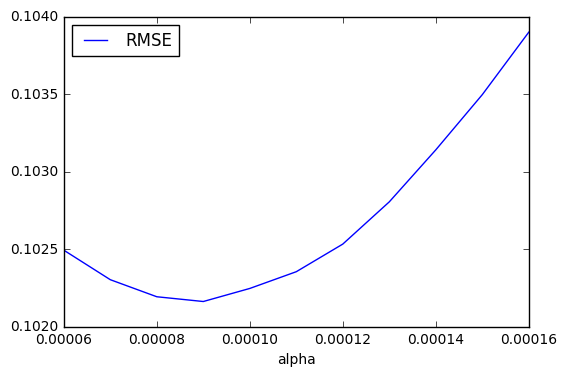

In [20]:
lassolars_params = {'alpha': np.arange(0.00006, 0.00016, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [35]:
lassolars_regr = linear_model.LassoLars(alpha=0.00009, max_iter=50000)

In [36]:
validate(lassolars_regr)

0.11040524690491826

## Elastic Net

In [21]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [22]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RandomizedSearchCV took 72.88 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.00031486540055768528, 'l1_ratio': 0.66223429349062668}

Model with rank: 2
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.00031162842090145469, 'l1_ratio': 0.57873792628575804}

Model with rank: 3
Mean validation score: -0.011 (std: 0.002)
Parameters: {'alpha': 0.00040796895027502814, 'l1_ratio': 0.55135670796615444}



alpha                    RMSE                 std dev
0  0.00010000000000000000  0.10572408577817858644  0.04893596128027177805
8  0.00090000000000000008  0.10444797760964232014  0.04521892296704541764
7  0.00080000000000000004  0.10417422494901559804  0.04530524283706931915
1  0.00020000000000000001  0.10393146782692826158  0.04770217671149882405
6  0.00070000000000000010  0.10392438636657831685  0.04543694875675616252
5  0.00060000000000000006  0.10363119193033375198  0.04567357051775635529
2  0.00030000000000000003  0.10334012300950216889  0.04675452162383476190
4  0.00050000000000000001  0.10333256885839801897  0.04592991850432007889
3  0.00040000000000000002  0.10320814020931325106  0.04617436995368802422

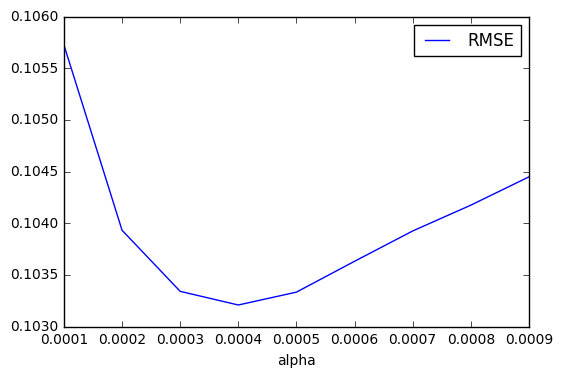

In [23]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0010, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

l1_ratio                    RMSE                 std dev
0  0.10000000000000000555  0.10546216698267493750  0.04772595397064743200
1  0.20000000000000001110  0.10439056800213943055  0.04707616811760824416
8  0.90000000000000002220  0.10383623220555979194  0.04584774699722201502
2  0.30000000000000004441  0.10370965473693581627  0.04677952343646078759
7  0.80000000000000004441  0.10363599055020700224  0.04597257759718265113
6  0.70000000000000006661  0.10338249714447085570  0.04603376556100809841
3  0.40000000000000002220  0.10337746896102639749  0.04644647940703609812
5  0.59999999999999997780  0.10321230876579963465  0.04606116020655062065
4  0.50000000000000000000  0.10320814020931325106  0.04617436995368802422

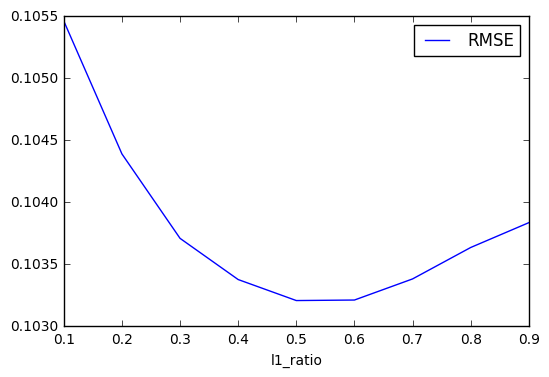

In [37]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [44]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, l1_ratio=0.55, max_iter=15000, random_state=7)

In [45]:
validate(elnet_regr)

0.11470125819781042

## Random Forest

In [24]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [25]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,40), 
             'max_features': scipy.stats.randint(5,80)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 272.18 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 72, 'n_estimators': 313, 'max_depth': 37}

Model with rank: 2
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 62, 'n_estimators': 345, 'max_depth': 25}

Model with rank: 3
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 71, 'n_estimators': 353, 'max_depth': 25}



n_estimators                    RMSE                 std dev
0           50.0  0.12416935126110666132  0.05052306305832561517
1          100.0  0.12241808794656704185  0.05268250316563589941
3          200.0  0.12223109507974067034  0.05304563451991533424
2          150.0  0.12222091558797547328  0.05275413294183315532
4          250.0  0.12199245813805408012  0.05271430329122289010
7          400.0  0.12180490900833176870  0.05217139409793832006
8          450.0  0.12178876372373759196  0.05234084969569093027
6          350.0  0.12170153709727897506  0.05196020968669294582
9          500.0  0.12166682285126284579  0.05260060550941333957
10         550.0  0.12162787625060524077  0.05288490454935600160
11         600.0  0.12159758691611308179  0.05302161018643512108
5          300.0  0.12159532025576999525  0.05235893491793251059

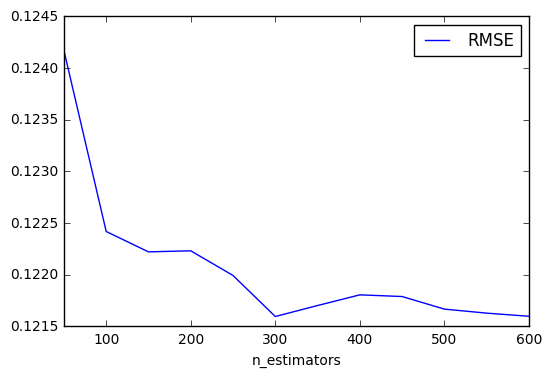

In [55]:
rf_regr = RandomForestRegressor(n_estimators = 313, max_depth = 28, max_features = 79, random_state = 7)
rf_params = {'n_estimators': np.arange(50, 650, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [62]:
rf_regr = RandomForestRegressor(n_estimators = 300, max_depth = 28, max_features = 79, random_state = 7)

In [63]:
validate(rf_regr)

0.13096736523931515

## Support Vector Regressor

In [26]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 50.15 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.002)
Parameters: {'kernel': 'rbf', 'C': 6.1870818356615827, 'gamma': 0.0066614674976186276}

Model with rank: 2
Mean validation score: -0.015 (std: 0.002)
Parameters: {'kernel': 'rbf', 'C': 0.42561922956261111, 'gamma': 0.019452340417077128}

Model with rank: 3
Mean validation score: -0.016 (std: 0.002)
Parameters: {'kernel': 'rbf', 'C': 0.63537599238785447, 'gamma': 0.025302607970082019}



C                    RMSE                 std dev
9  11.5  0.11119542014244793160  0.04665835767111697896
8  11.0  0.11112777742348142751  0.04662354253467408671
7  10.5  0.11105799010713598984  0.04655081881322870735
6  10.0  0.11099306977258069362  0.04647169984899318651
5   9.5  0.11092572621548218992  0.04644772746181536488
4   9.0  0.11086328142215866321  0.04638791811451977581
3   8.5  0.11079045621524068188  0.04626843072890138298
2   8.0  0.11074059334821674538  0.04610054245916825333
1   7.5  0.11069826485554350171  0.04585204156512847490
0   7.0  0.11066196877536908783  0.04557294229452008710

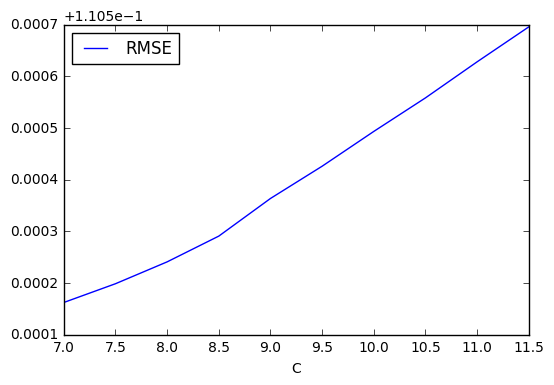

In [52]:
svr_regr = svm.SVR(C=6.2, cache_size=200, coef0=0.0, degree=3, gamma=0.002,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(7, 12, 0.5).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [56]:
svr_regr = svm.SVR(C=7, cache_size=200, coef0=0.0, degree=3, gamma=0.002,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [57]:
validate(svr_regr)

0.12335285689083843

## Orthogonal Matching Pursuit

In [28]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [29]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 5.44 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.002)
Parameters: {'n_nonzero_coefs': 96}

Model with rank: 1
Mean validation score: -0.011 (std: 0.002)
Parameters: {'n_nonzero_coefs': 96}

Model with rank: 3
Mean validation score: -0.011 (std: 0.002)
Parameters: {'n_nonzero_coefs': 111}



n_nonzero_coefs                    RMSE                 std dev
5             129.0  0.10688231507934355113  0.04697946406781331602
3             127.0  0.10685798275767278975  0.04722660873277255422
4             128.0  0.10685771947809150073  0.04667100718295857931
1             125.0  0.10671689082562887951  0.04721091876394019338
6             130.0  0.10669398299625970639  0.04706009405472896118
2             126.0  0.10669359960427637901  0.04742529217561654298
0             124.0  0.10648001383032633382  0.04696114737321356591
7             131.0  0.10642188768993141035  0.04687654292048799159
8             132.0  0.10633433676248679745  0.04689682284149559316
10            134.0  0.10621975445439310604  0.04648734704331335121
9             133.0  0.10612694748843845560  0.04655765900715340411

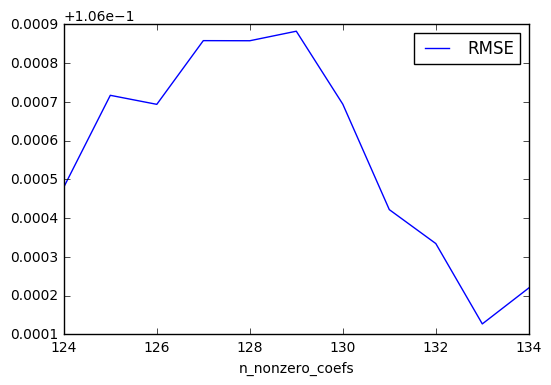

In [48]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=55)
omp_params = {'n_nonzero_coefs': np.arange(124, 135, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [53]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=133)

In [54]:
validate(omp_regr)

0.12252419373128547

## XGBoost

In [30]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 6885.45 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.002)
Parameters: {'reg_alpha': 0.72647988913656147, 'colsample_bytree': 0.16518764142953724, 'learning_rate': 0.4627639110092201, 'min_child_weight': 0.48627059663098998, 'n_estimators': 469, 'subsample': 0.24124644353448821, 'reg_lambda': 1.2996425334435149, 'max_depth': 1, 'gamma': 0.056654718519083901}

Model with rank: 2
Mean validation score: -0.016 (std: 0.002)
Parameters: {'reg_alpha': 0.017714959172157058, 'colsample_bytree': 0.43197638052877663, 'learning_rate': 0.14803988515837707, 'min_child_weight': 2.6015121340186669, 'n_estimators': 455, 'subsample': 0.65100037983798353, 'reg_lambda': 0.031032658386604281, 'max_depth': 3, 'gamma': 0.4411744332270584}

Model with rank: 3
Mean validation score: -0.017 (std: 0.003)
Parameters: {'reg_alpha': 0.71181586262345753, 'colsample_bytree': 0.90852772158127815, 'learning_rate': 0.089027062947860669, 'm

n_estimators                    RMSE                 std dev
9        2000.0  0.11080600153041270106  0.04747458007264152707
7        1800.0  0.11072280767326715678  0.04704613711250391767
2        1300.0  0.11069596654430285954  0.04737825468671915535
6        1700.0  0.11069184568633752552  0.04702022644153392578
0        1100.0  0.11067201140195305487  0.04647310220124942215
8        1900.0  0.11066049318380445643  0.04725304396639307819
3        1400.0  0.11064382082765859827  0.04736520720601302553
1        1200.0  0.11060770325503078981  0.04691685540943279359
5        1600.0  0.11058004755357234150  0.04725653683109274500
4        1500.0  0.11051723221931746000  0.04713733475999903194

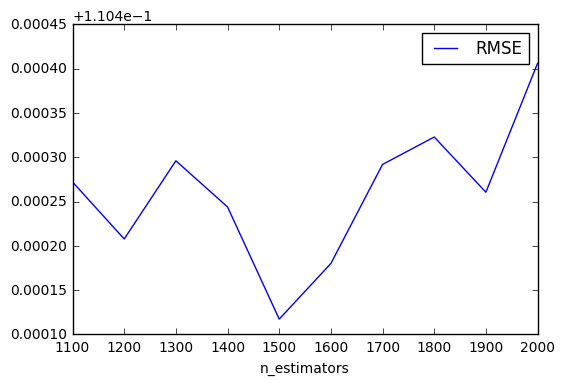

In [74]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 5.1,
    gamma = 0.01,
    subsample = 0.7,
    colsample_bytree = 0.3,
    reg_alpha = 0.6,
    reg_lambda = 1.8, 
    learning_rate = 0.2,
    n_estimators = 469,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(1100, 2100, 100).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [75]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 5.1,
    gamma = 0.01,
    subsample = 0.7,
    colsample_bytree = 0.3,
    reg_alpha = 0.6,
    reg_lambda = 1.8, 
    learning_rate = 0.2,
    n_estimators = 1500,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [76]:
validate(xgb_regr)

0.12224939734835051

## MLP Regressor

In [31]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [32]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 1792.72 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.003)
Parameters: {'alpha': 7.0091346823066011e-05, 'max_iter': 214.89408080986556, 'tol': 2.1956094410854298e-05, 'hidden_layer_sizes': 84}

Model with rank: 2
Mean validation score: -0.019 (std: 0.004)
Parameters: {'alpha': 3.0916540899813092e-05, 'max_iter': 432.69956733080943, 'tol': 6.3727572307887829e-05, 'hidden_layer_sizes': 287}

Model with rank: 3
Mean validation score: -0.019 (std: 0.002)
Parameters: {'alpha': 7.855133045870163e-07, 'max_iter': 423.37530227782929, 'tol': 4.7128218920380142e-05, 'hidden_layer_sizes': 380}



max_iter                    RMSE                 std dev
0      25.0  0.12771822435858648515  0.04633454245826263557
1      50.0  0.11310044955524176102  0.04960355248825497332
2      75.0  0.10985007159129561716  0.04677530632664750332
6     175.0  0.10850397037736457528  0.04760907936179957500
3     100.0  0.10842153403961128644  0.04401456672547431753
8     225.0  0.10824255338159595452  0.04859124623165327755
7     200.0  0.10807968939039079570  0.04819100885030202369
5     150.0  0.10806645190203487128  0.04320837955646122941
4     125.0  0.10795161353106852431  0.04313785051590004332

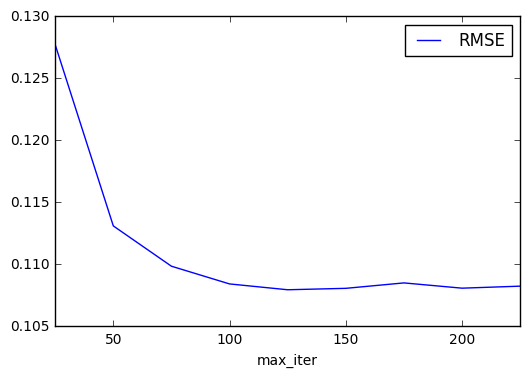

In [70]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.000008, 
                        tol=0.0002, 
                        max_iter=214)
mlp_params = {'max_iter': np.arange(25, 250, 25).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [72]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.000008, 
                        tol=0.0002, 
                        max_iter=125)

In [73]:
validate(mlp_regr)

0.12102494329812304